In [1]:
# !pip install kaggle

In [2]:
# !mkdir ~/.kaggle

In [1]:
!pwd

/Users/harvey/Documents/Studies/Computer Science/Deep Learning/HW1P2


In [2]:
# !kaggle competitions download -c idl-fall2021-hw1p2

In [3]:
# !unzip idl-fall2021-hw1p2.zip -d Data/

In [4]:
# !conda install matplotlib

# Global Settings

In [1]:
GLOBALTEST = False

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import torch.optim as optim

from torch.utils import data

%matplotlib inline

In [3]:
cuda = torch.cuda.is_available()
if cuda: print("Using cuda!!") 
else: print("No cuda available")

Using cuda!!


# Loading Data

In [5]:
real_paths = ["Data/train.npy", "Data/train_labels.npy", "Data/dev.npy", "Data/dev_labels.npy"]
toy_paths = ["Data/toy_train_data.npy", "Data/toy_train_label.npy", "Data/toy_val_data.npy", "Data/toy_val_label.npy"]

paths = real_paths

train_data = np.load(paths[0], allow_pickle=True)
train_label = np.load(paths[1], allow_pickle=True)
test_data = np.load(paths[2], allow_pickle=True)
test_label = np.load(paths[3], allow_pickle=True)

In [6]:
print(train_data.shape)
print(train_data[0].shape)

(14542,)
(1184, 40)


In [7]:
print(train_label.shape)
print(train_label[0].shape)

(14542,)
(1184,)


In [8]:
train_data = train_data[:]
train_label = train_label[:]
test_data = test_data[:]
test_label = test_label[:]

## Dataset

In [9]:
from dataset import MyDataset

## Dataloader

In [10]:
num_workers = 0 if cuda else 0 
context_size = 10

# Training
train_dataset = MyDataset(train_data, train_label, context_size = context_size)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
test_dataset = MyDataset(test_data, test_label, context_size = context_size)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

del train_data
del test_data
del train_label
del test_label

In [11]:
print(len(train_dataset))
# print(list(test_loader))

18482968


# Model and Loss Function

In [12]:
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [13]:
model = Simple_MLP([40*(2*context_size+1), 256, 128, 71])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=840, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=71, bias=True)
  )
)


# Training Procedure

In [14]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [15]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

## Training

In [16]:
n_epochs = 5
save = True
Train_loss = []
Test_loss = []
Test_acc = []

state_dict = torch.load("Models/Trial1Epoch5.pth", map_location=torch.device(device))
model.load_state_dict(state_dict)

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    if save:
        torch.save(model.state_dict(), "checkpoint.pth")
    print('='*20)

KeyboardInterrupt: 

## Result Visualization

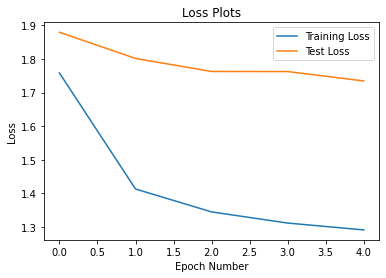

In [90]:
plt.title('Loss Plots')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss, label='Training Loss')
plt.plot(Test_loss, label = 'Test Loss')
plt.legend()
plt.show()

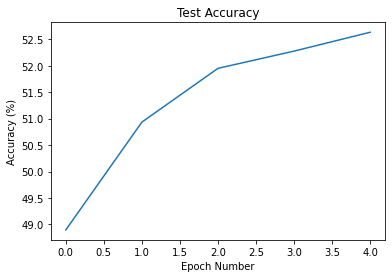

In [91]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)
plt.show()